# Research Question No. 5
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))

plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_gcc_path = "datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv"
reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"

results_eclipse_path = "datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv"
reports_eclipse_path = "datasets/20190917_eclipse_bug_report_data.csv"

print("Setup complete")

Setup complete


# 3. Load data

In [3]:
    !echo "\nHeader of metrics file $reports_gcc_path"
    !head -n 2 $reports_gcc_path

    !echo "\nNumber of lines in the file $reports_gcc_path"
    !wc -l $reports_gcc_path
    
    !echo "\nHeader of metrics file $results_eclipse_path"
    !head -n 2 $results_eclipse_path

    !echo "\nNumber of lines in the file $results_eclipse_path"
    !wc -l $results_eclipse_path


Header of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2

Number of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv

Header of metrics file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
4DIAC-489747,139,Y,N

Number of lines in the file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.cs

In [5]:
# read data.
reports_gcc_data  = pd.read_csv(reports_gcc_path)
rows_and_cols = reports_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_gcc_path}.\n")

results_gcc_data = pd.read_csv(results_gcc_path)
rows_and_cols = results_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_gcc_path}.\n")


reports_eclipse_data  = pd.read_csv(reports_eclipse_path)
rows_and_cols = reports_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_eclipse_path}.\n")

results_eclipse_data = pd.read_csv(results_eclipse_path)
rows_and_cols = results_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_eclipse_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv.

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

There are 2408 rows and 4 columns in datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [6]:
results_gcc_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,CLASSPATH-16983,15,N,N
1,CLASSPATH-17008,342,N,N
2,CLASSPATH-17060,337,N,N
3,CLASSPATH-18312,5,N,N
4,CLASSPATH-21635,96,N,N


In [7]:
reports_gcc_data['long_lived_computed']  = reports_gcc_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [8]:
reports_gcc_data['long_lived_computed'].head()

0    short-lived
1    short-lived
2     long-lived
3    short-lived
4    short-lived
Name: long_lived_computed, dtype: object

In [9]:
results_eclipse_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,4DIAC-489747,139,Y,N
1,4DIAC-495630,38,Y,Y
2,4DIAC-500078,38,Y,Y
3,4DIAC-511266,0,N,N
4,4DIAC-518907,200,Y,N


In [10]:
reports_eclipse_data['long_lived_computed']  = reports_eclipse_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [11]:
reports_eclipse_data['long_lived_computed'].head()

0    short-lived
1    short-lived
2    short-lived
3    short-lived
4    short-lived
Name: long_lived_computed, dtype: object

## 4.2 Results analysis

In [12]:
def plot_bar(data, status, column, top_all_10, ax):
    plt.rc('font', size=SMALL_SIZE+5)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE+5)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE+5)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE+15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE+15)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE+5)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE+5)  # fontsize of the figure title

    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    
    colors  = top_n[column].apply(lambda t: 'tab:red' if (top_all_10[column] == t).sum() > 0 else 'tab:blue')
    
    plt.sca(ax)
    plt.bar(top_n[column], top_n['count'], color=colors)
    plt.xticks(rotation='vertical')
    #plt.xlabel(font_size=2)
    
    ax.set(title=f"prediction: {status}", xlabel="", ylabel="Count")

def plot_bar_(data, status, column, ax):
    
    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    #top_n = top_n.sort_values('count', ascending=False).head(10)
    
    #colors  = top_n[column].apply(lambda t: 'tab:red' if (top_all_10[column] == t).sum() > 0 else 'tab:blue')
    
    plt.sca(ax)
    plt.bar(top_n[column], top_n['count'], color='blue')
    plt.xticks(rotation='vertical')
    
    ax.set(title=f"prediction: {status}", xlabel="", ylabel="Count")


In [13]:
results_gcc_merged_data = pd.merge(
    reports_gcc_data,
    results_gcc_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_eclipse_merged_data = pd.merge(
    reports_eclipse_data,
    results_eclipse_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)

In [14]:
long_lived_gcc_predicted_bugs = results_gcc_merged_data.query('long_lived == "Y"')
long_lived_gcc_predicted_bugs.loc[:, 'status_prediction']  = long_lived_gcc_predicted_bugs.loc[:, 'y_hat'].apply(lambda t: 'correct' if t == 'Y' else 'incorrect')
long_lived_eclipse_predicted_bugs = results_eclipse_merged_data.query('long_lived == "Y"')
long_lived_eclipse_predicted_bugs.loc[:, 'status_prediction']  = long_lived_eclipse_predicted_bugs.loc[:, 'y_hat'].apply(lambda t: 'correct' if t == 'Y' else 'incorrect')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Reporter Name

### GCC

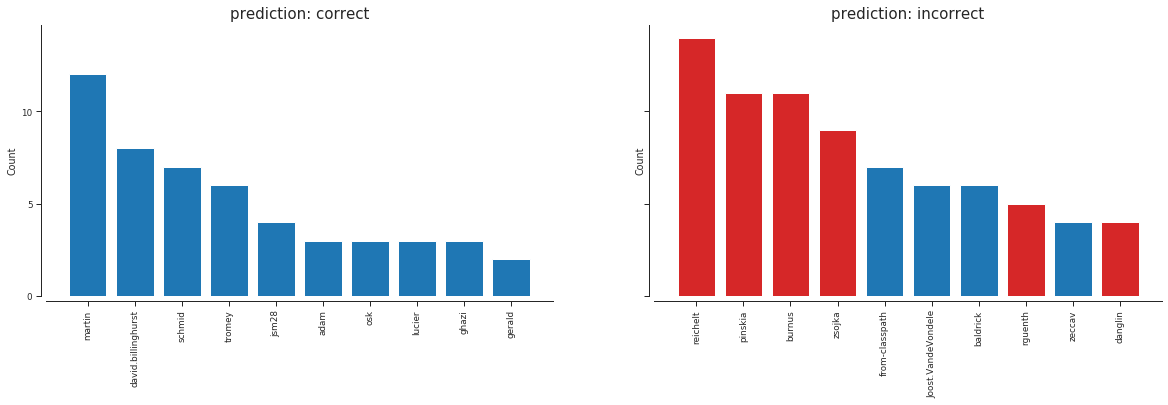

In [15]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=2.0)

top_10_reporters = reports_gcc_data.groupby(['reporter_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_reporters = top_10_reporters.sort_values('count', ascending=False).head(10)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_gcc_predicted_bugs, status, 'reporter_name', top_10_reporters, ax)

### Eclipse

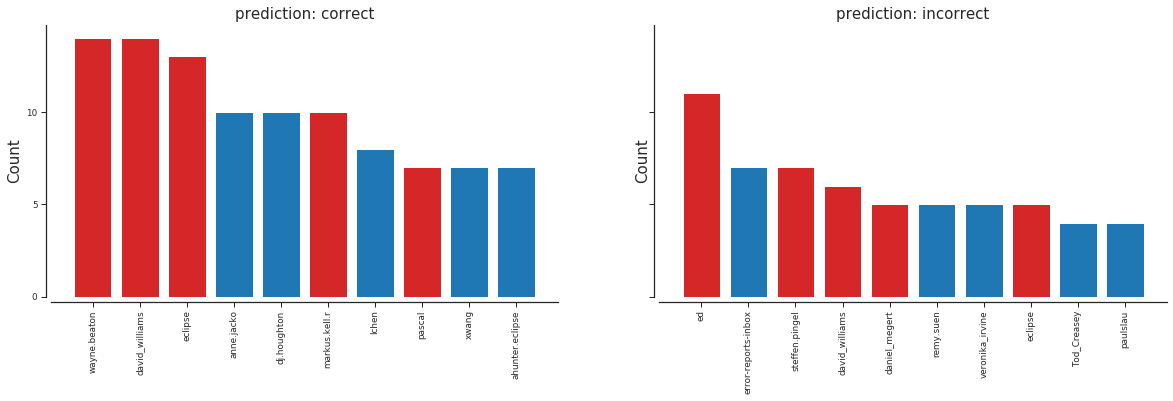

In [16]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=2.0)

top_10_reporters = reports_eclipse_data.groupby(['reporter_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_reporters = top_10_reporters.sort_values('count', ascending=False).head(10)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_eclipse_predicted_bugs, status, 'reporter_name', top_10_reporters, ax)

### Assignee

### GCC

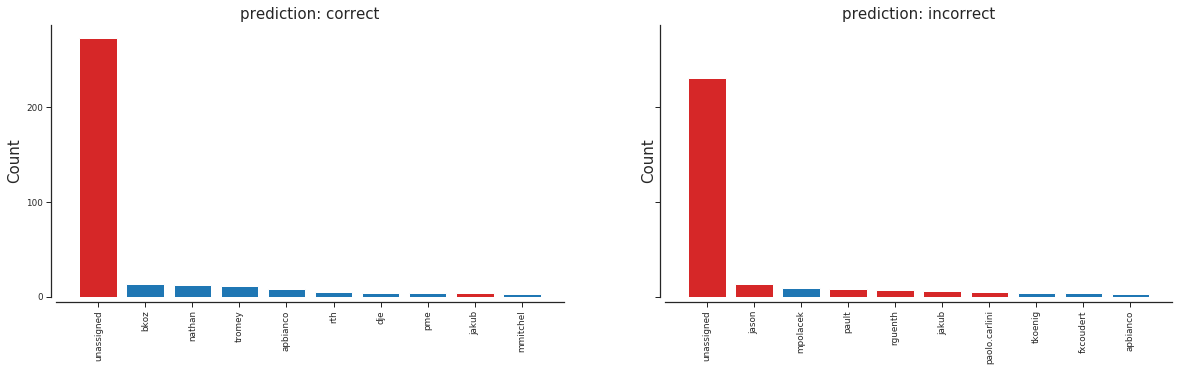

In [17]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

top_10_assignees = reports_gcc_data.groupby(['assignee_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_assignees = top_10_assignees.sort_values('count', ascending=False).head(10)


for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_gcc_predicted_bugs, status, 'assignee_name', top_10_assignees, ax)

### Eclipse

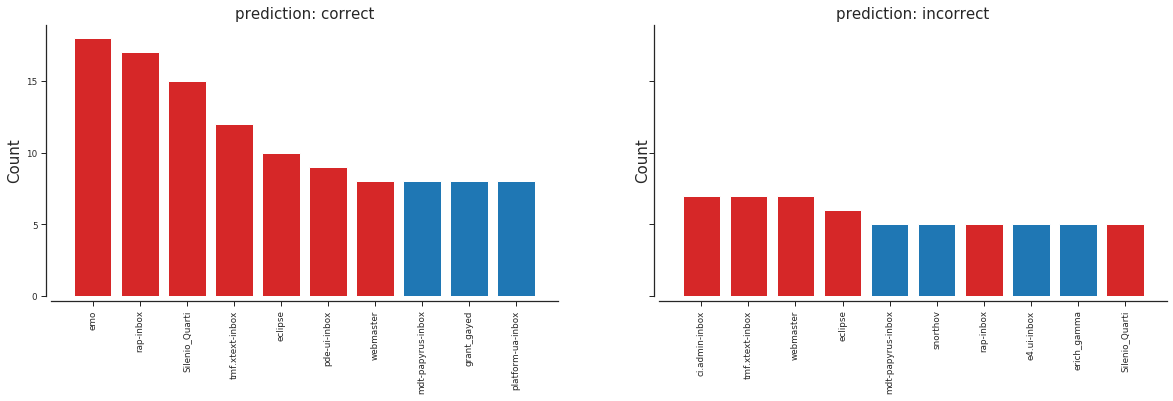

In [18]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

top_10_assignees = reports_eclipse_data.groupby(['assignee_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_assignees = top_10_assignees.sort_values('count', ascending=False).head(10)


for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_eclipse_predicted_bugs, status, 'assignee_name', top_10_assignees, ax)

### Component Name

### GCC

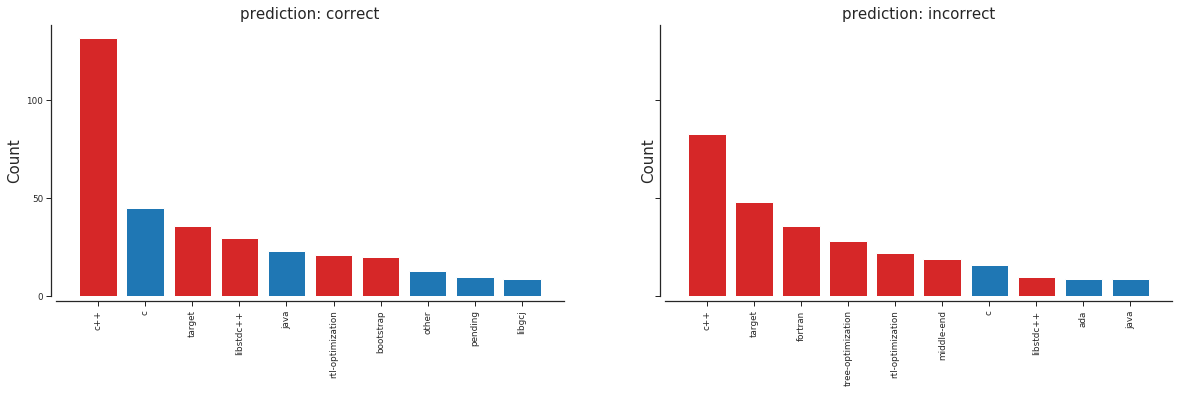

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

top_10_components = reports_gcc_data.groupby(['component_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_components = top_10_components.sort_values('count', ascending=False).head(10)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_gcc_predicted_bugs, status, 'component_name', top_10_components, ax)

### Eclipse

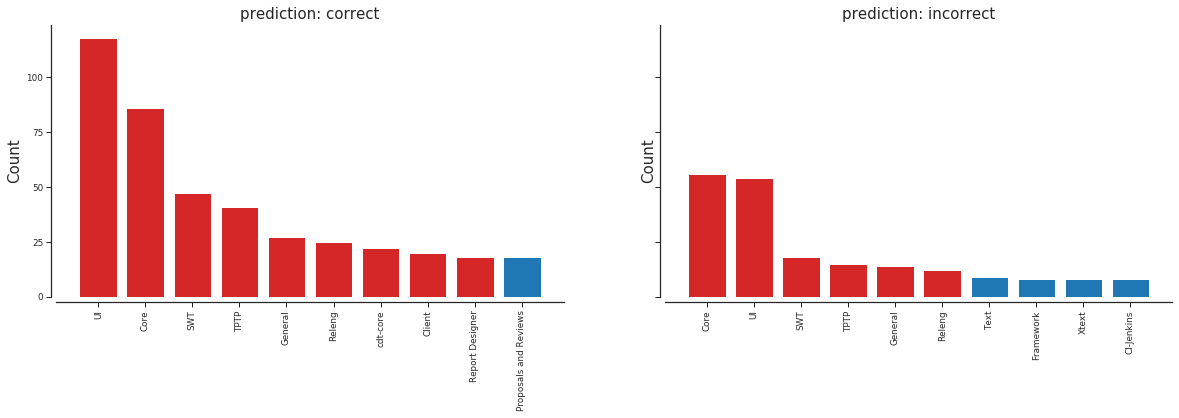

In [20]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)

sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

top_10_components = reports_eclipse_data.groupby(['component_name', "long_lived_computed"]).size().reset_index(name='count')
top_10_components = top_10_components.sort_values('count', ascending=False).head(10)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar(long_lived_eclipse_predicted_bugs, status, 'component_name', top_10_components, ax)

### Severity Level

### GCC

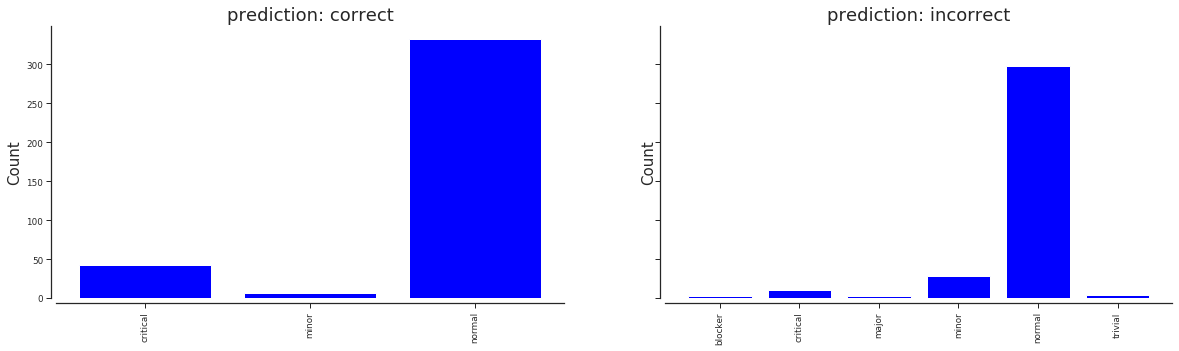

In [21]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar_(long_lived_gcc_predicted_bugs, status, 'severity_category', ax)

### Eclipse

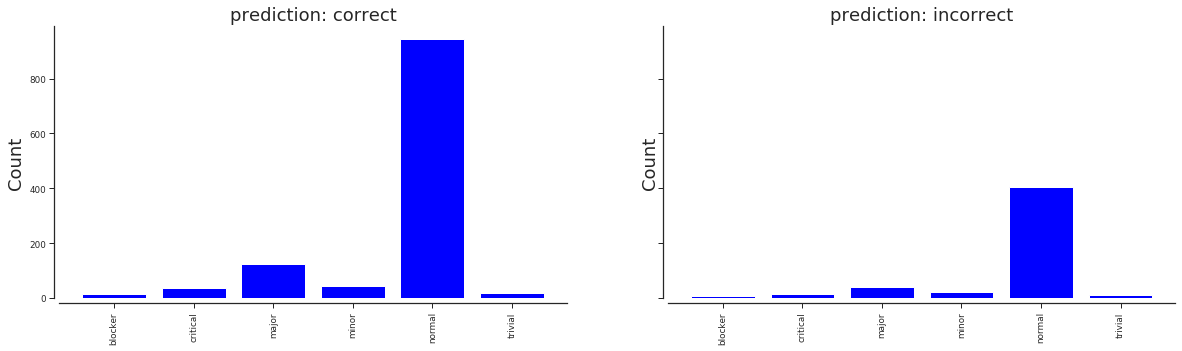

In [22]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20,5))
plt.subplots_adjust(hspace=0.8)
sns.set_context("paper")
sns.despine(offset=5)
sns.set(style="ticks", color_codes=True, font_scale=1.5)

for status, ax in zip(['correct', 'incorrect'], axes.flatten()):
    plot_bar_(long_lived_eclipse_predicted_bugs, status, 'severity_category', ax)

### Description 
Existem muitas palavras relacionadas com código(stop words).

#### Word cloud

<table width="100%">
    <tbody>
        <tr>
            <td>Corrected</td>
            <td>Incorrected</td>
        </tr>
        <tr>
        <td>
<img src="datasets/wordcloud-gcc-corrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>
        </td>
        <td>
<img src="datasets/wordcloud-gcc-incorrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>            
        </td>
        </tr>
     </tbody>
</table>

#### Histograms 

<table width="100%">
    <tbody>
        <tr>
        <td>
<img src="datasets/histfreq-gcc-corrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>
        </td>
        <td>
<img src="datasets/histfreq-gcc-incorrected-predicted-bugs.png" alt="Drawing" style="width: 100%;"/>            
        </td>
        </tr>
     </tbody>
</table>